# Opening and processing kwik files

Importing

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

## Opening the KWIK file

Opening a KWIK file and returning the spike information

In [3]:
def read_spikes_sample_and_clu(session):
    #chgroup is channel group (shank)
    #cluGroup is the group of the cluster (noise, mua, good...)
    spikeSample,clusterGroup={},{}
    spikeIndex={}
    channelGroupList = {}
    first = True
    for chgroup in session.model.channel_groups:
        if first:
            first = False
        else:
            session.change_channel_group(chgroup)
        spikeSample[chgroup]={}
        clusterGroup[chgroup]={}
        spikeIndex[chgroup]={}
        #self.channelGroupList[chgroup] = list(session.model.channel_order)
        #default cluster group names (0: 'Noise', 1: 'MUA', 2: 'Good', 3: 'Unsorted')
        for cluGroupName in session.model.default_cluster_groups.values():
            clusterGroup[chgroup][cluGroupName]=[]
            
        #for every cluster in the channel_group
        for clu in session.model.cluster_ids:
            spikeSample[chgroup][clu]=session.model.spike_samples[session.model.spike_clusters==clu]  
            #spikeIndex[chgroup][clu]=session.model.spike_ids[session.model.spike_clusters==clu]
            cluGroupID=session.model.cluster_metadata.group(clu)
            if isinstance(cluGroupID, np.ndarray):
                print("Warning- cluster group of cluster %s is an array (%s), taking first value"%(clu,cluGroupID))
                cluGroupID=cluGroupID[0]
            if isinstance(cluGroupID, bytes):
                print("Warning- cluster group of cluster %s is a bytes, putting it in 'unsorted'"%(clu))
                cluGroupID = 3
            # if a group was created (ID>3), put it in "Good"(2)
            if cluGroupID>3:
                cluGroupID=2
            cluGroupName=session.model.default_cluster_groups[cluGroupID]        
            clusterGroup[chgroup][cluGroupName].append(clu)
    #self.spikeIndex=spikeIndex
    return spikeSample,clusterGroup

def open_kwik_file(inputFile):
    """
    This function opens a kwik file using KWIKphy session package, 
    and returns spike times and types of Good and MUA clusters
    """
    if not os.path.exists(inputFile):
        print("%s\nKWIK file not found!"%(inputFile))
        return False
    from KWIKphy.session import Session
        
    try:
        sessionInfo=Session(inputFile)
        print("KWIK file loaded!")
    except Exception as e:
        print("KWIKphy failed to open the KWIK file:")
        print(inputFile)
        print(repr(e))
        return False
    
    spikeSample,clusterGroup=read_spikes_sample_and_clu(sessionInfo)
    print("Done!")
    return spikeSample,clusterGroup



#----------------------------------------------------------------
if "__file__" not in dir():
   
    inputFile="/data/SWI002/2/SWI002_2016_09_20_12_52/SWI002_2016_09_20_12_52.kwik"
    a=open_kwik_file(inputFile)
    print(a[1])

    

        



Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
KWIK file loaded!
Done!
{0: {'Noise': [], 'Good': [], 'MUA': [], 'Unsorted': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]}}


## Peocessing

Firing rate

Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
KWIK file loaded!
Done!


/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in reciprocal


plotting...
[ 13.93404552] [ 785.78967501]


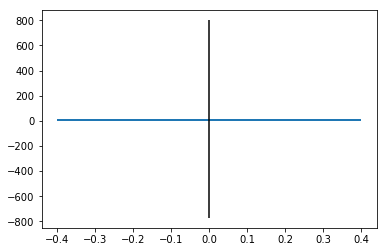

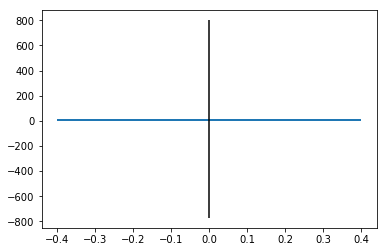

In [6]:
def compute_firing_rate(data):
    """
    This functions computes firing rate of a SINGLE neuron
    data: spike times as a np.array vector
    output: 
    """
    ISI=np.diff(data)
    return np.median (np.reciprocal(ISI.astype('float')))

def plot_median_firing_rate(spikeSample,clusterGroup,samplingRate,
                            cluToPlot=['Good']):
        
    if type(cluToPlot) is str:
        cluToPlot=cluToPlot.split()    #turns into a list
    
    neuralFiringRate=np.empty((len(cluToPlot),
                               len(spikeSample),
                               len(spikeSample[0])))*np.nan
    #neuralFiringRate=cluType*shank*cluster
    
    for cluType in cluToPlot:
        for shank in spikeSample:
            for clu in clusterGroup[shank][cluType]:
                neuralFiringRate[cluToPlot.index(cluType),
                                 shank,
                                 clusterGroup[shank][cluType].index(clu)]\
                                 =compute_firing_rate(spikeSample[shank][clu]/samplingRate)
    #Plotting
    print('plotting...')
    for shank in spikeSample:
        plt.figure()
        Median=np.empty(len(cluToPlot))*np.nan
        Std =np.empty(len(cluToPlot))*np.nan
        for cluType in cluToPlot:
            Median[cluToPlot.index(cluType)]=np.nanmedian(\
                                                      neuralFiringRate[cluToPlot.index(cluType),
                                                                       shank,
                                                                       :])
            Std[cluToPlot.index(cluType)]=np.nanstd(\
                                                    neuralFiringRate[cluToPlot.index(cluType),
                                                                     shank,
                                                                     :])
        print(Median,Std)
        plt.bar(left=range(len(cluToPlot)),
                height=Median,
                yerr=Std)
        plt.show()
            
    
       
    
#---------------------------------------------------------
if "__file__" not in dir():
    path="/data/SWI002/2/SWI002_2016_09_20_12_52/SWI002_2016_09_20_12_52.kwik"
    spikeSample,clusterGroup=open_kwik_file(path)
    plot_median_firing_rate(spikeSample,clusterGroup,30000,'Unsorted')

In [ ]:
plt.gca()
plt.bar(left=[1],
       height=[12]
       )